In [60]:
%reload_ext autoreload
%autoreload 2

# What jobs?

In [61]:
from Scratch import metadata_loader


DEVICE = "ibm_torino"
LOGICAL = str(0)
XBASIS = False
ROUNDS = 50

state = "X" if XBASIS else "Z"
state += LOGICAL
print(f"state = {state}")

# Load the metadata
md = metadata_loader(True, True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["code"] == "RepetitionCodeCircuit"]
md = md[md["descr"] == 'subset RepCodes']
md = md.dropna(subset=["rounds"])
md = md[md["meas_level"] == 1]
md['rounds'] = md['rounds'].astype(int)
md['distance'] = md['distance'].astype(int)

md = md[md["backend_name"] == DEVICE]
md = md[md["logical"] == LOGICAL]
md = md[md["xbasis"] == XBASIS]
md = md[md["rounds"] == ROUNDS]

md = md[:40]
print("shape:", md.shape)
md[:2]

state = Z0
shape: (40, 18)


,creation_date,notebook_name,backend_name,job_id,tags,meas_level,shots,num_qubits,job_status,execution_date,code,distance,rounds,logical,descr,resets,xbasis,path_info
5483,2024-03-24 15:59:50.864000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zsqdvs8g008j7ra0,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:51:12.990431+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."
5482,2024-03-24 15:59:44.592000+01:00,Torino_RepCodes_jobs,ibm_torino,cr03zr7k5z700081s2tg,"[Subset 56, 50 rounds, 0 log, xbasis=False]",1.0,1398.0,NaN,JobStatus.DONE,2024-03-24 16:50:44.865382+01:00,RepetitionCodeCircuit,56,50,0,subset RepCodes,NaN,False,"{'mean_gate_error': 0.006452510204489, 'min_ga..."


# Load the data

In [62]:
import json

SOFT_MUL = 0.5

# file_name = f'../results/{state}_{ROUNDS}.json'
file_name = f'../results/{DEVICE}_{state}_{ROUNDS}_soft_{SOFT_MUL}.json'


with open(file_name, 'r') as f:
    decoding_data = json.load(f)

print(len(decoding_data.keys()))

40


# Get the cummulative error dict

In [63]:
import numpy as np

distances = list(range(3, md["distance"].values[0] + 1, 4))
err_rate_dict = {d: [{}, 0] for d in distances}

for index, row in md.iterrows():
    decoding_results = decoding_data[row["job_id"]]
    shots = row["shots"]
    for result in decoding_results:
        d_new = int(result["d_new"])
        decoding = result["decoding"]
        num_errors = np.sum(result["error_list"])
        num_subsets = len(result["error_list"])
        if decoding not in err_rate_dict[d_new][0]:
            err_rate_dict[d_new][0][decoding] = []
        err_rate_dict[d_new][0][decoding].append(num_errors)
        err_rate_dict[d_new][1] += shots * num_subsets/2 # bcs twice for hard and kde & times the nb of subsets


print(err_rate_dict)

mean_err_rate_dict = {}
for d in distances:
    mean_err_rate_dict[d] = {}
    for decoding in err_rate_dict[d][0]:
        mean_err_rate_dict[d][decoding] = np.sum(err_rate_dict[d][0][decoding]) 
    mean_err_rate_dict[d]["shots"] = err_rate_dict[d][1]

print(mean_err_rate_dict)


{3: [{'kde': [7190, 7124, 6897, 7077, 7019, 7032, 7100, 7363, 7060, 6746, 6827, 6649, 6860, 6762, 6884, 6857, 7011, 7100, 6889, 7075, 7405, 7288, 7345, 7191, 7018, 7109, 6900, 7135, 6719, 6733, 6697, 6831, 6847, 7097, 7002, 6808, 7109, 7119, 7209, 7137], 'hard': [8387, 8393, 8167, 8214, 8286, 8299, 8417, 8598, 8535, 7955, 8150, 7841, 8029, 8036, 8048, 8044, 8298, 8297, 8047, 8397, 8695, 8613, 8580, 8496, 8489, 8419, 8132, 8454, 8032, 7937, 7818, 8107, 8114, 8283, 8409, 8061, 8487, 8350, 8526, 8515]}, 1565760.0], 7: [{'kde': [1487, 1509, 1408, 1418, 1394, 1419, 1474, 1461, 1473, 1299, 1333, 1301, 1318, 1300, 1404, 1339, 1431, 1448, 1427, 1469, 1519, 1513, 1554, 1344, 1427, 1445, 1385, 1397, 1348, 1314, 1275, 1349, 1367, 1434, 1372, 1393, 1376, 1412, 1479, 1395], 'hard': [2148, 2092, 1981, 2032, 1996, 2001, 2075, 2127, 2123, 1909, 1884, 1841, 1921, 1930, 1970, 1934, 1952, 1976, 2074, 2058, 2139, 2143, 2229, 2000, 2014, 1989, 1958, 2054, 1923, 1968, 1872, 1979, 1952, 1969, 1882, 1986, 206

# Plot

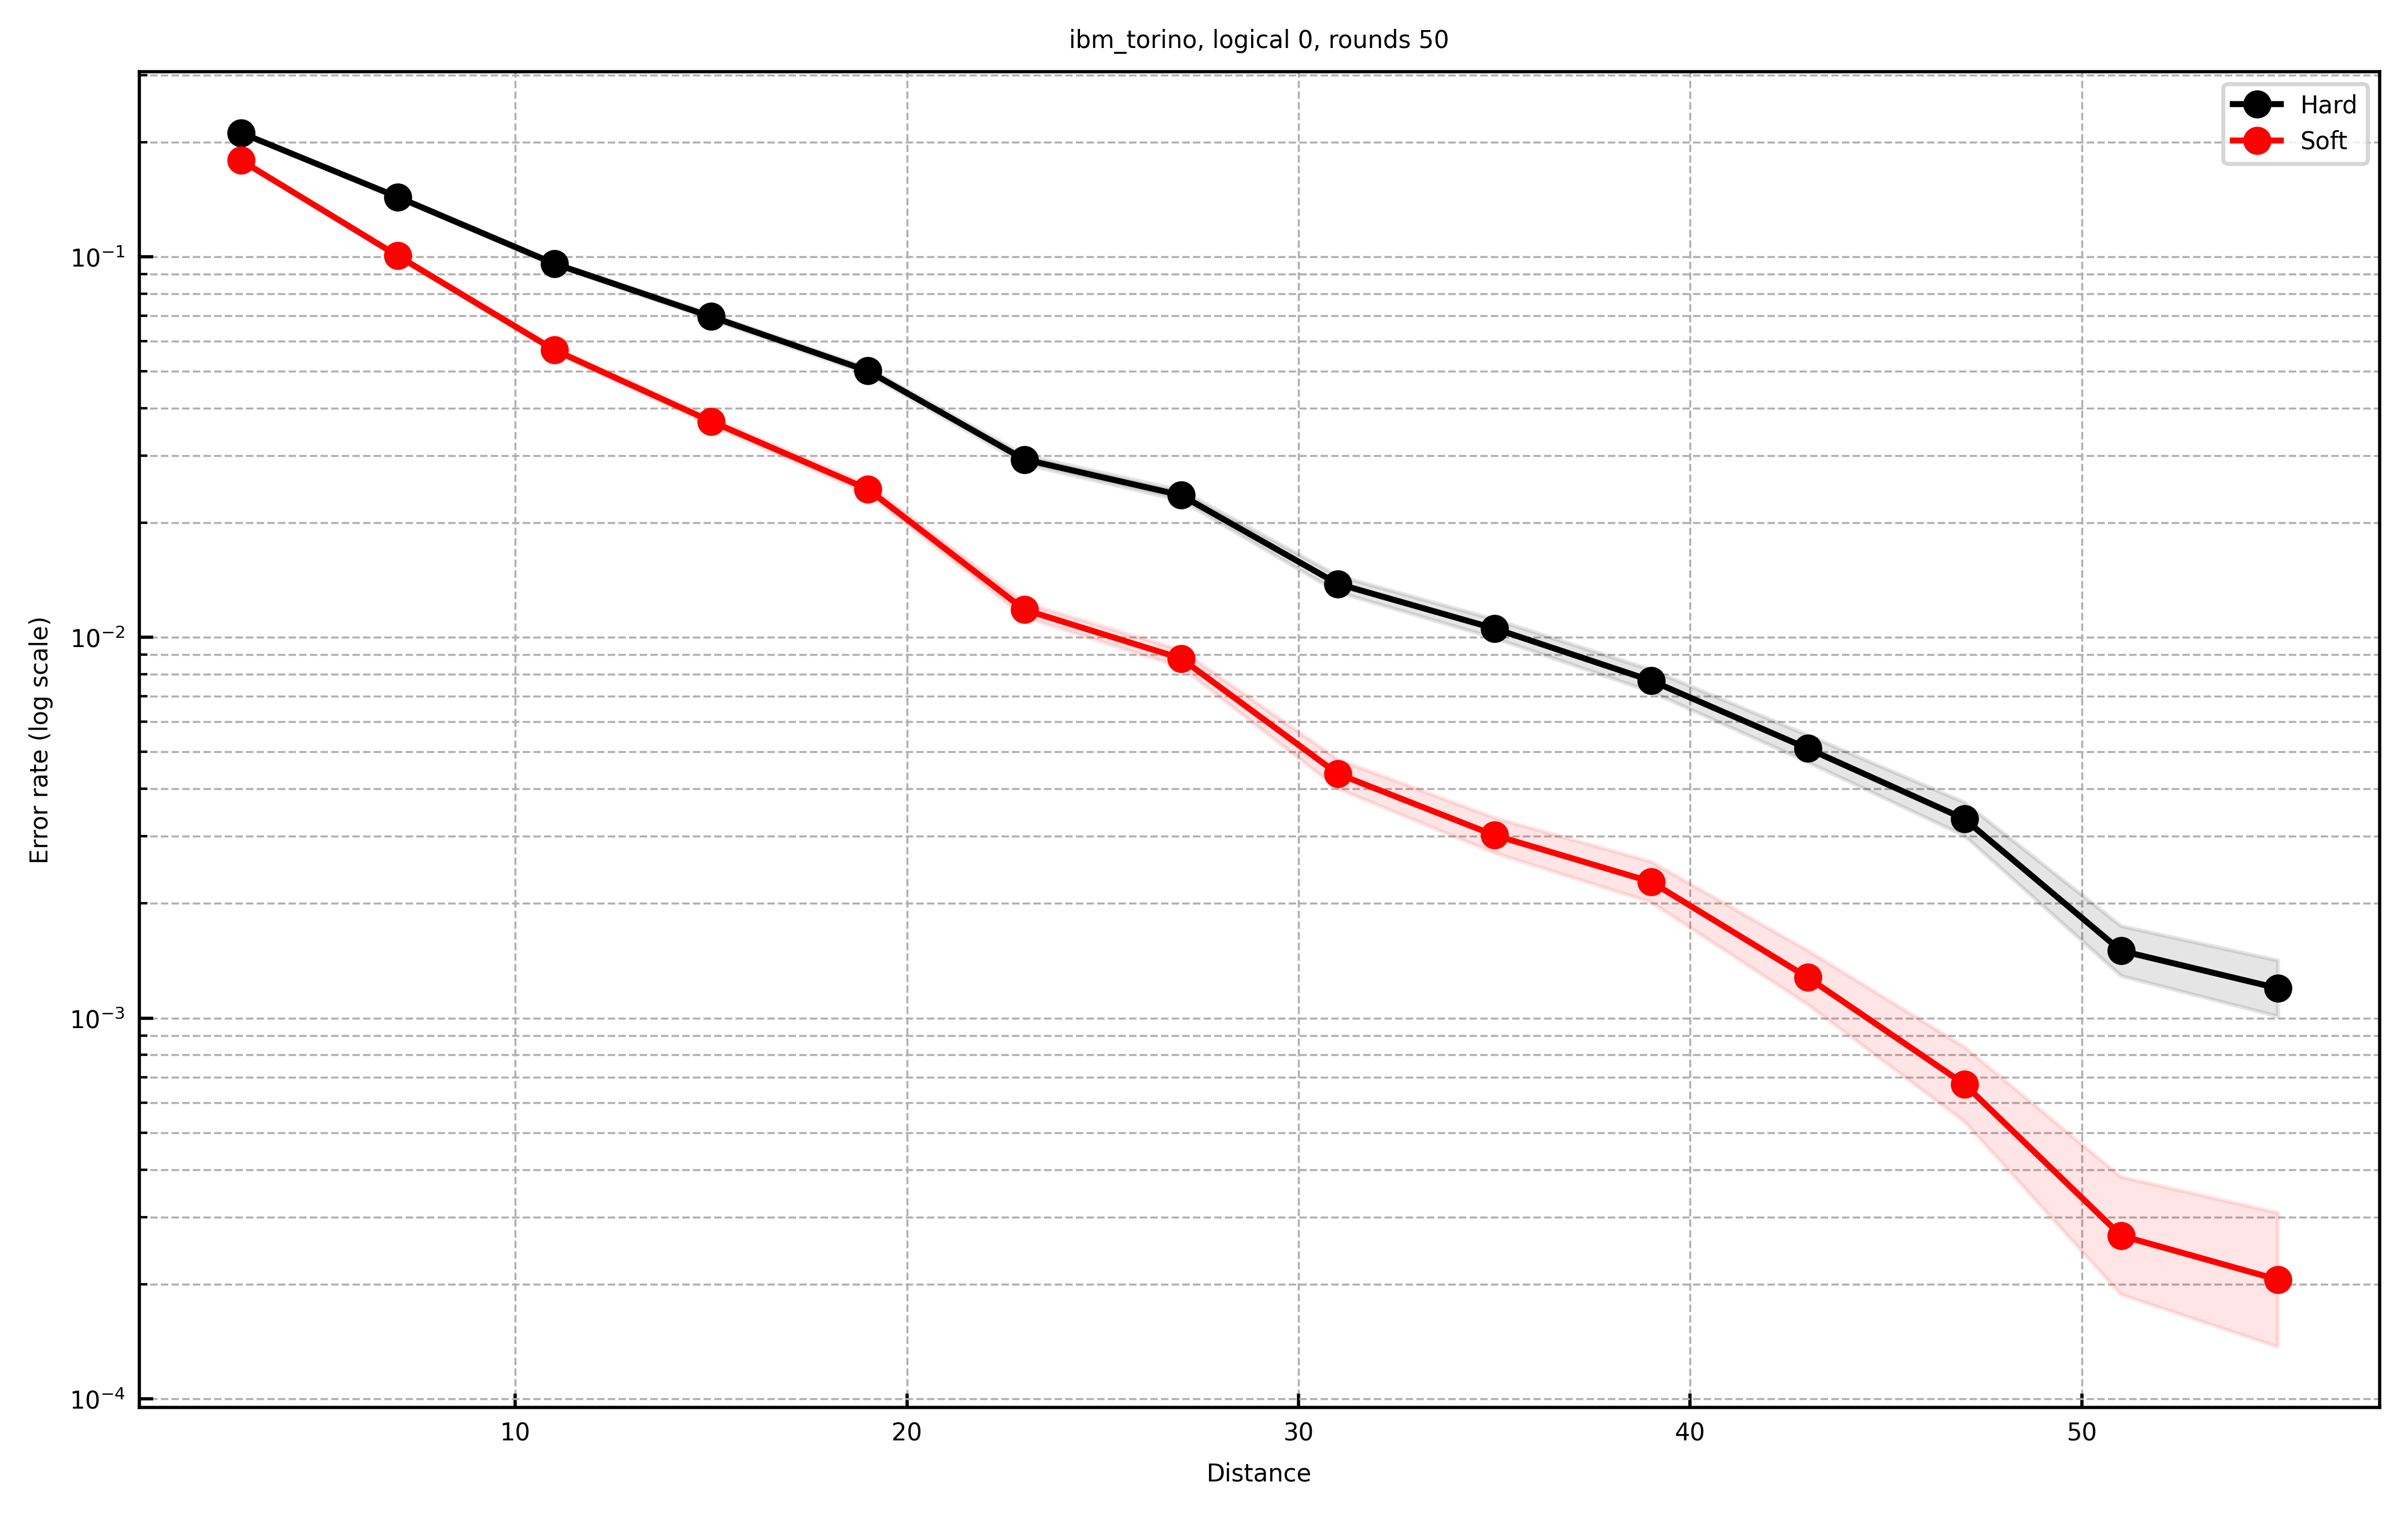

In [64]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

FIGURE_WIDTH_1COL = 3.404  # For PRX style, change for according to journal
FIGURE_WIDTH_2COL = 7.057  # For PRX style, change for according to journal
FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL*2/(1 + np.sqrt(5))*1.1
FIGURE_HEIGHT_2COL_GR = FIGURE_WIDTH_2COL*2/(1 + np.sqrt(5))*1.1

font_size = 6 # For PRX style, change for according to journal

plt.rcParams.update({
    'font.size'           : font_size,  
    'figure.titlesize'    : 'medium',
    'figure.dpi'          : 500,
    'figure.figsize'      : (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
    'axes.titlesize'      : 'medium',
    'axes.axisbelow'      : True,
    'xtick.direction'     : 'in',
    'xtick.labelsize'     : 'small',
    'ytick.direction'     : 'in',
    'ytick.labelsize'     : 'small',
    'image.interpolation' : 'none',
    'legend.fontsize'     : font_size,
    'axes.labelsize'      : font_size,
    'axes.titlesize'      : font_size,
    'xtick.labelsize'     : font_size,
    'ytick.labelsize'     : font_size,
})


# Wilson score interval function
def wilson_score_interval(p, n, z=1.96):  # Using z=1.96 for a 95% confidence interval
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)

err_rates_hard = []
err_rates_soft = []
hard_lowers = []
hard_uppers = []
soft_lowers = []
soft_uppers = []

for d in distances:
    # For 'hard' decoding
    p_hard = mean_err_rate_dict[d]["hard"]/mean_err_rate_dict[d]["shots"]
    err_rates_hard.append(p_hard)
    lower_hard, upper_hard = wilson_score_interval(p_hard, mean_err_rate_dict[d]["shots"])
    hard_lowers.append(lower_hard)
    hard_uppers.append(upper_hard)

    # For 'soft' decoding
    p_soft = mean_err_rate_dict[d]["kde"]/mean_err_rate_dict[d]["shots"]
    err_rates_soft.append(p_soft)
    lower_soft, upper_soft = wilson_score_interval(p_soft, mean_err_rate_dict[d]["shots"])
    soft_lowers.append(lower_soft)
    soft_uppers.append(upper_soft)

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

# Plotting error rates for 'hard' and 'soft', including confidence intervals
plt.plot(distances, err_rates_hard, label="Hard", marker='o', color='black')
plt.fill_between(distances, hard_lowers, hard_uppers, color='black', alpha=0.1)
plt.plot(distances, err_rates_soft, label="Soft", marker='o', color='red')
plt.fill_between(distances, soft_lowers, soft_uppers, color='red', alpha=0.1)

plt.yscale("log")
plt.ylabel('Error rate (log scale)')
plt.xlabel('Distance')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.legend()
plt.title(f"{DEVICE}, logical {LOGICAL}, rounds {ROUNDS}")

plt.show()

In [65]:
# zip the distances and the error rates together
data = list(zip(distances, err_rates_hard, err_rates_soft))
data

[(3, 0.2113701972205191, 0.1789680410790926),
 (7, 0.14338340486409157, 0.10051859799713878),
 (11, 0.09583333333333334, 0.05686397234144015),
 (15, 0.06958154506437768, 0.036923283261802574),
 (19, 0.050120708154506435, 0.02451716738197425),
 (23, 0.029327610872675252, 0.011820457796852646),
 (27, 0.023623032904148782, 0.00880424415832141),
 (31, 0.013823319027181688, 0.004381258941344778),
 (35, 0.010550786838340487, 0.0030221745350500714),
 (39, 0.007698497854077253, 0.0022800429184549357),
 (43, 0.005105507868383405, 0.0012786123032904149),
 (47, 0.0033351216022889842, 0.0006706008583690987),
 (51, 0.0015021459227467812, 0.0002682403433476395),
 (55, 0.001198140200286123, 0.00020565092989985694)]

In [66]:
# print the rates between the two decodings
for d, hard, soft in data:
    print(f"distance {d}: ratio {hard/soft:.2f}")

distance 3: ratio 1.18
distance 7: ratio 1.43
distance 11: ratio 1.69
distance 15: ratio 1.88
distance 19: ratio 2.04
distance 23: ratio 2.48
distance 27: ratio 2.68
distance 31: ratio 3.16
distance 35: ratio 3.49
distance 39: ratio 3.38
distance 43: ratio 3.99
distance 47: ratio 4.97
distance 51: ratio 5.60
distance 55: ratio 5.83
